In [ ]:
# 참조
# https://ichi.pro/ko/scikit-pandas-mich-numpyleul-sayonghan-sigyeyeol-modelling-114547776927953

In [ ]:
import pandas as pd
import numpy as np

url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
data = pd.read_csv(url,sep=",")
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.18400,NaN,NaN,NaN
2006-01-02,1380.52100,NaN,NaN,NaN
2006-01-03,1442.53300,NaN,NaN,NaN
2006-01-04,1457.21700,NaN,NaN,NaN
2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131


In [ ]:
# 성능 평가 함수

import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
data_consumption = data[['Consumption']]

# 하루 전 컬럼 생성
data_consumption.loc[:, 'Yesterday'] = data_consumption.loc[:,'Consumption'].shift()

# 어제 오늘 차이 컬럼 생성
data_consumption.loc[:, 'Yesterday_Diff'] = data_consumption.loc[:, 'Yesterday'].diff()

# 결측치 제거
data_consumption = data_consumption.dropna()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [ ]:
# 학습 / 테스트 데이터 생성
X_train = data_consumption[:'2016'].drop(['Consumption'], axis = 1)
y_train = data_consumption.loc[:'2016', 'Consumption']
X_test = data_consumption['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption.loc['2017', 'Consumption']

LR: 0.343747 (0.029773)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

NN: 0.523017 (0.104532)
KNN: 0.646307 (0.083185)
RF: 0.611748 (0.084410)
SVR: -0.117944 (0.157755)


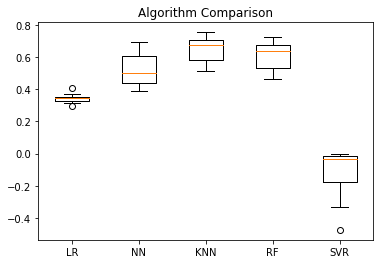

In [ ]:
# TimeSeriesSplit KFold

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [ ]:
# 하이퍼 파라미터 최적화

from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [ ]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.7349
mean_squared_log_error:  0.004
r2:  0.7328
MAE:  54.9886
MSE:  7234.9662
RMSE:  85.0586


In [ ]:
# t-1일의 값을 사용하여 t값을 예측했다. 이제 (t-2)일의 값을 사용하여 소비량을 예측
# creating copy of original dataframe
data_consumption_2o = data_consumption.copy()
# inserting column with yesterday-1 values
data_consumption_2o['Yesterday-1'] = data_consumption_2o['Yesterday'].shift()
# inserting column with difference in yesterday-1 and yesterday-2 values.
data_consumption_2o['Yesterday-1_Diff'] = data_consumption_2o['Yesterday-1'].diff()
# dropping NAs
data_consumption_2o = data_consumption_2o.dropna()

In [ ]:
X_train_2o = data_consumption_2o[:'2016'].drop(['Consumption'], axis = 1)
y_train_2o = data_consumption_2o.loc[:'2016', 'Consumption']
X_test = data_consumption_2o['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption_2o.loc['2017', 'Consumption']

In [ ]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o, y_train_2o)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8412
mean_squared_log_error:  0.0025
r2:  0.8412
MAE:  40.5539
MSE:  4301.681
RMSE:  65.5872


In [ ]:
# 태양열 생산의 가치를 더하는 것이 전기 소비를 예측하는 데 어떤면에서 도움이되는지 살펴 보겠습니다.
data_consumption_2o_solar = data_consumption_2o.join(data[['Solar']])
data_consumption_2o_solar = data_consumption_2o_solar.dropna()

In [ ]:
X_train_2o_solar = data_consumption_2o_solar[:'2016'].drop(['Consumption'], axis = 1)
y_train_2o_solar = data_consumption_2o_solar.loc[:'2016', 'Consumption']
X_test = data_consumption_2o_solar['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption_2o_solar.loc['2017', 'Consumption']
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o_solar, y_train_2o_solar)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.837
mean_squared_log_error:  0.0025
r2:  0.8367
MAE:  40.4503
MSE:  4421.2302
RMSE:  66.4923


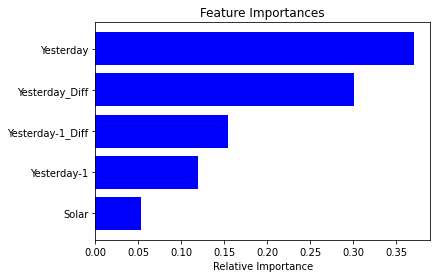

In [ ]:
# 변수 중요도 파악
imp = best_model.feature_importances_
features = X_train_2o_solar.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# 데이터 세트에 계절적 요소가 있다는 것을 기억할 것입니다. 더 정확하게는 주간 계절성이 있습니다. 
# 따라서 주어진 날짜 이전 주에 모델에 대한 입력, 소비 값으로 공급하는 것이 더 합리적입니다. 
# 즉, 모델이 1 월 8 일에 소비 가치를 예측하려는 경우 1 월 1 일에 소비에 대한 정보를 제공해야합니다

data_consumption_2o_solar_weeklyShift = data_consumption_2o_solar.copy()
data_consumption_2o_solar_weeklyShift['Last_Week'] = data_consumption_2o_solar['Consumption'].shift(7)
data_consumption_2o_solar_weeklyShift = data_consumption_2o_solar_weeklyShift.dropna()

In [ ]:
X_train_2o_solar_weeklyShift = data_consumption_2o_solar_weeklyShift[:'2016'].drop(['Consumption'], axis = 1)
y_train_2o_solar_weeklyShift = data_consumption_2o_solar_weeklyShift.loc[:'2016', 'Consumption']
X_test = data_consumption_2o_solar_weeklyShift['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption_2o_solar_weeklyShift.loc['2017', 'Consumption']
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o_solar_weeklyShift, y_train_2o_solar_weeklyShift)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8924
mean_squared_log_error:  0.0017
r2:  0.8918
MAE:  31.3372
MSE:  2931.0662
RMSE:  54.1393


In [ ]:
# 우리가 올바르게 가정했듯이, 일의 값은 (t-7)일의 값보다 훨씬 더 강력한 예측 변수 (t-1)입니다.

# 시계열 데이터에 대한 교차 검증을 수행하고, 모델 하이퍼 파라미터를 미세 조정하는 방법을 배웠습니다. 
# 또한 전력 소비 예측을 위해 RMSE를 85.61에서 54.57로 성공적으로 줄였습니다.